# Predicting Purchases from Clickstream Data

The objective of the case study is to predict whether a session will result in a purchase given a sequence of click events from an e-commerce website.

---
### Table of Contents:

1. Load datasets, packages, and parameters
2. Clickstream Exploratory Analysis
3. Purchase Response Variable
4. Feature Table
5. Binary Classification Model Training
6. Regression Model Training
7. Inference

---

# 1. Load datasets, packages, and parameters

In [37]:
%reload_kedro
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from imblearn.over_sampling import SMOTE

from process.pipelines.data_processing import nodes as dp
from process.pipelines.data_science import nodes as ds

2021-12-15 15:29:54,096 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-12-15 15:29:54,186 - root - INFO - ** Kedro project Purchase Predictions
2021-12-15 15:29:54,187 - root - INFO - Defined global variable `context`, `session` and `catalog`


In [ ]:
clickstream = catalog.load('clickstream').sort_values(by = ['session_id', 'timestamp']).set_index('session_id')
purchase = catalog.load('purchase').sort_values(by = ['session_id', 'timestamp']).set_index('session_id')
test = catalog.load('test').sort_values(by = ['session_id', 'timestamp']).set_index('session_id')
warnings.filterwarnings('ignore')

2021-12-15 15:29:54,359 - kedro.io.data_catalog - INFO - Loading data from `clickstream` (CSVDataSet)...
2021-12-15 15:30:20,079 - kedro.io.data_catalog - INFO - Loading data from `purchase` (CSVDataSet)...
2021-12-15 15:30:20,923 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...


# 2. Clickstream Exploratory Data Analysis

- We will need to generate the following features:
    - Total Clicks per Session
    - Total Seconds per Session
    - Count unique item id per 
    - One hot encoding for category
- Generate statistical distributions for clicks, seconds, and unique items.
- Key Takeaways

In [ ]:
clickstream.head()

In [ ]:
clickstream[clickstream.index == 9194132]

In [ ]:
total_clicks = dp.total_clicks(clickstream)
clickstream = clickstream.join(total_clicks, how='left')

seconds_per_session = dp.total_seconds(clickstream)
clickstream = clickstream.join(seconds_per_session['seconds_per_session']).drop('timestamp', axis = 1).drop_duplicates()

unique_items = dp.count_unique_items(clickstream)
clickstream = clickstream.join(unique_items).drop('item_id', axis = 1).drop_duplicates()

category_map = dp.category_map(clickstream)
clickstream = clickstream.join(pd.get_dummies(category_map)).drop(['category', 'category_map'], axis = 1).drop_duplicates()

clickstream.head()

In [ ]:
dp.stat_plots(clickstream, 'total_clicks')
print('--------------------------------------------------------------------------------------------------------------------')
dp.stat_plots(clickstream, 'seconds_per_session')
print('--------------------------------------------------------------------------------------------------------------------')
dp.stat_plots(clickstream, 'count_unique_items')

In [ ]:
category_dist = pd.concat([clickstream['brand'].value_counts(normalize = True),
                            clickstream['missing'].value_counts(normalize = True),
                            clickstream['regular'].value_counts(normalize = True),
                            clickstream['special offer'].value_counts(normalize = True)], 
                          axis = 1)
dp.stacked_bar_chart(category_dist, 'Table Coverage by Category')

In [ ]:
average_clicks_by_category = pd.concat([clickstream.groupby('brand').total_clicks.mean(),
                                        clickstream.groupby('missing').total_clicks.mean(),
                                        clickstream.groupby('regular').total_clicks.mean(),
                                        clickstream.groupby('special offer').total_clicks.mean()], axis = 1)
average_clicks_by_category.columns = ['brand','missing','regular','special offer']
dp.stacked_bar_chart(average_clicks_by_category, 'Average Clicks by Category')

In [ ]:
average_seconds_by_category = pd.concat([clickstream.groupby('brand').seconds_per_session.mean(),
                                         clickstream.groupby('missing').seconds_per_session.mean(),
                                         clickstream.groupby('regular').seconds_per_session.mean(),
                                         clickstream.groupby('special offer').seconds_per_session.mean()], axis = 1)
average_seconds_by_category.columns = ['brand','missing','regular','special offer']
dp.stacked_bar_chart(average_seconds_by_category, 'Average Seconds by Category')

In [ ]:
average_items_by_category = pd.concat([clickstream.groupby('brand').count_unique_items.mean(),
                                         clickstream.groupby('missing').count_unique_items.mean(),
                                         clickstream.groupby('regular').count_unique_items.mean(),
                                         clickstream.groupby('special offer').count_unique_items.mean()], axis = 1)
average_items_by_category.columns = ['brand','missing','regular','special offer']
dp.stacked_bar_chart(average_items_by_category, 'Average Distinct Items by Category')

### Key Takeaways
- Continuous variables: Total clicks, seconds per session, count of unique items
    - These variables have postive skew distributions.
- Categorical variables (one-hot encoded): brand, missing, regular, special offer
    - Special offers have the highest coverage in the dataset
    - Missing have the highest number of clicks, distinct items, and average seconds per sessoin

---

# 3. Purchase Response Variable

In [ ]:
purchase.head()

In [ ]:
purchase['revenue'] = purchase['price'] * purchase['quantity'] 
total_revenue = purchase.groupby(level=0).revenue.sum()
dp.stat_plots(total_revenue.reset_index(), 'revenue')

# 4. Feature Table

In [ ]:
feature_table = dp.add_revenue(clickstream, purchase)
feature_table = dp.total_number_purchases(feature_table)
feature_table.head()

There isn't a large difference in average revenue by category:

In [ ]:
average_revenue_category = pd.concat([feature_table[feature_table.binary_revenue == 1].groupby(['brand']).revenue.mean(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['missing']).revenue.mean(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['regular']).revenue.mean(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['special offer']).revenue.mean()], axis = 1)
average_revenue_category.columns = ['brand','missing','regular','special offer']
dp.stacked_bar_chart(average_revenue_category, 'Average Revenue by Category')

Special offers have the highest total revenue:

In [ ]:
total_revenue_category = pd.concat([feature_table[feature_table.binary_revenue == 1].groupby(['brand']).revenue.sum(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['missing']).revenue.sum(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['regular']).revenue.sum(),
                                        feature_table[feature_table.binary_revenue == 1].groupby(['special offer']).revenue.sum()], axis = 1)
total_revenue_category.columns = ['brand','missing','regular','special offer']
dp.stacked_bar_chart(total_revenue_category, 'Total Revenue by Category')

Users with longer sessions have a higher average revenue total:

In [ ]:
conditions = [
    (feature_table.seconds_per_session >= 0) & (feature_table.seconds_per_session <= 200),
    (feature_table.seconds_per_session > 200) & (feature_table.seconds_per_session <= 800),
    (feature_table.seconds_per_session > 800)
]
choices = ['Short', 'Medium', 'Long']
feature_table['seconds_bin'] = np.select(conditions, choices, default=np.nan)
feature_table['seconds_bin'].value_counts(normalize = True)
feature_table.groupby('seconds_bin').revenue.mean().plot.bar()
print(feature_table.seconds_bin.value_counts(normalize = True))

In [ ]:
print("Pearson Correlation: ")
print(feature_table[feature_table.binary_revenue == 1][['revenue','seconds_per_session']].drop_duplicates().corr())
feature_table[feature_table.binary_revenue == 1][['revenue','seconds_per_session']].drop_duplicates().plot.scatter(x = 'seconds_per_session', y = 'revenue')

In [ ]:
feature_table = feature_table.drop('seconds_bin', axis = 1)
classification = feature_table.drop('revenue', axis = 1)
regression = feature_table[feature_table.binary_revenue == 1].drop('binary_revenue', axis = 1)

# 5. Binary Classification models

In [ ]:
classification.head()

In [69]:
X_train, X_test, y_train, y_test = ds._split_data(classification, 'binary_revenue', 0.25)

In [72]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

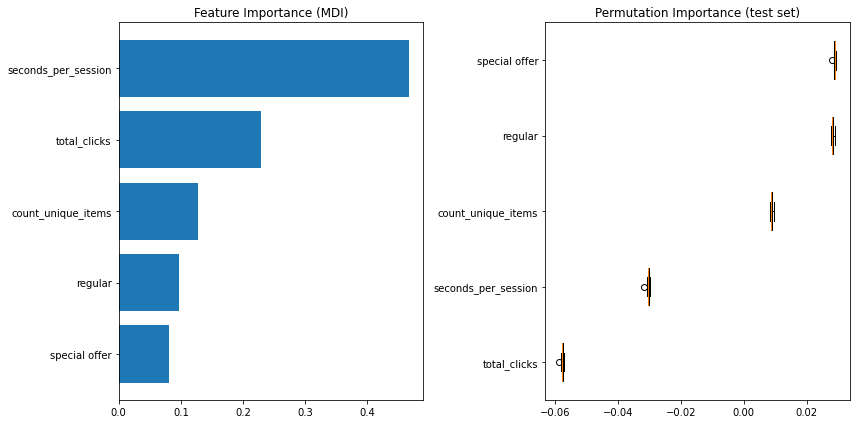

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    251310
           1       0.17      0.64      0.27     22235

    accuracy                           0.72    273545
   macro avg       0.56      0.68      0.55    273545
weighted avg       0.89      0.72      0.78    273545



In [29]:
randomForestClass, randomForestClass_metrics = ds.randomForestClassifier(X_res, X_test, y_res, y_test, 5)

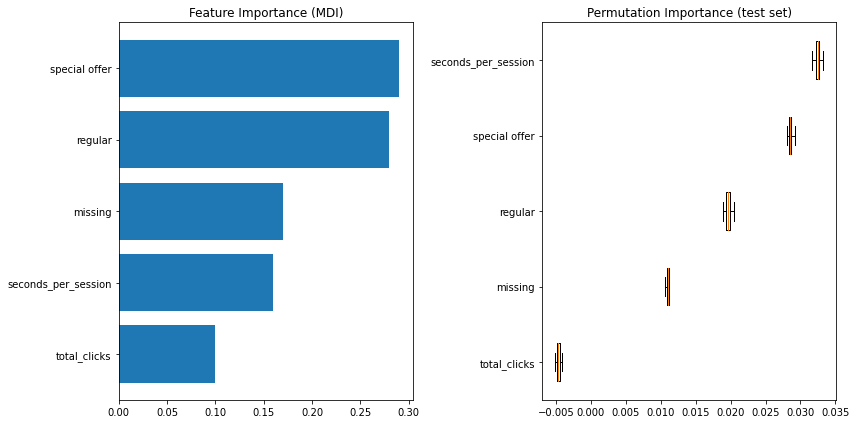

              precision    recall  f1-score   support

           0       0.96      0.67      0.79    251310
           1       0.15      0.69      0.25     22235

    accuracy                           0.67    273545
   macro avg       0.56      0.68      0.52    273545
weighted avg       0.89      0.67      0.74    273545



In [30]:
adaBoostClass, adaBoostClass_metrics = ds.adaBoostClassifier(X_res, X_test, y_res, y_test, 5)

[09:41:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

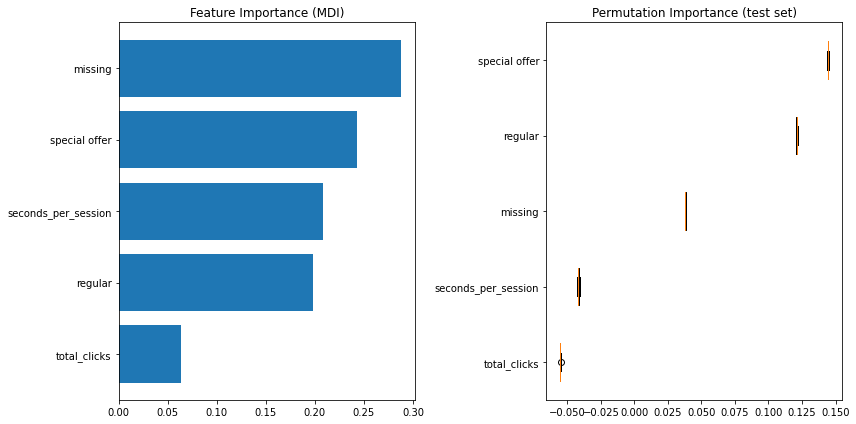

              precision    recall  f1-score   support

           0       0.95      0.75      0.84    251310
           1       0.17      0.58      0.26     22235

    accuracy                           0.74    273545
   macro avg       0.56      0.66      0.55    273545
weighted avg       0.89      0.74      0.79    273545



In [47]:
xgBoostClass, xgBoostClass_metrics = ds.xgboostClassifier(X_res, X_test, y_res, y_test, 5)

# 6. Regression Models

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = ds._split_data(regression, 'revenue', 0.25)

MSE: 120996487.9327
Explained variance: 0.031


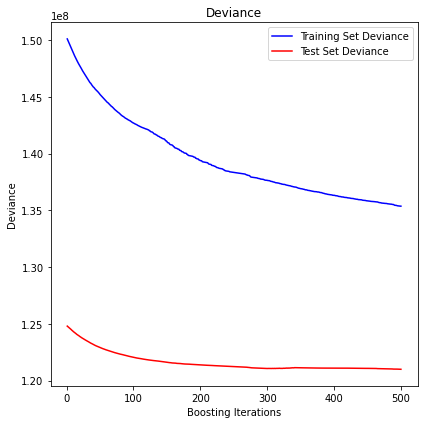

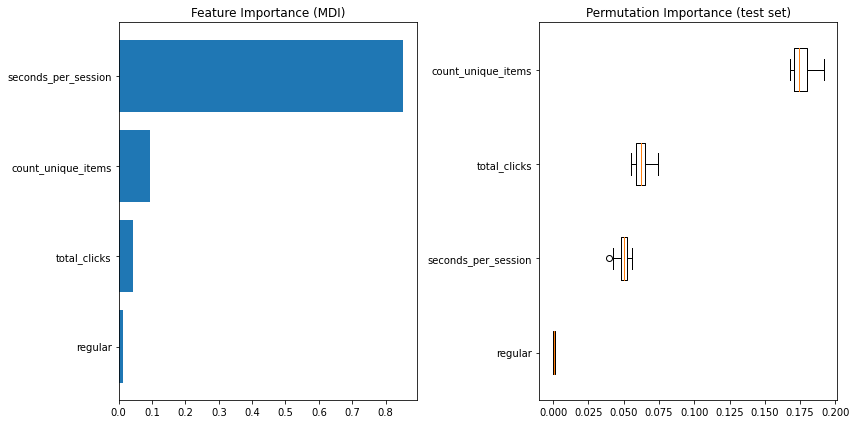

In [32]:
gradientBoostingRegressor, gradientBoostingRegressor_metrics = ds.gradientBoostingRegressor(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 5)

Base model with all features ...
MSE: 122943032.9075
Explained variance: 0.015


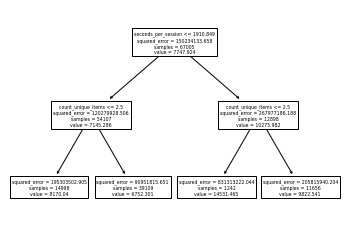

In [34]:
decisionTreeRegressor, decisionTreeRegressor_metrics = ds.DecisionTree(X_train_reg, X_test_reg, y_train_reg, y_test_reg)

# 7. Inference

In [45]:
test.head()

,timestamp,item_id,category
session_id,,,
11255548,2020-09-24 19:53:34.517,214830939,S
11255548,2020-09-24 19:53:48.774,214854444,S
11255548,2020-09-24 19:54:05.543,214830384,S
11255549,2020-09-25 10:25:55.459,214716973,1
11255549,2020-09-25 10:36:02.230,214716937,1


In [46]:
total_clicks = dp.total_clicks(test)
test = test.join(total_clicks, how='left')

seconds_per_session = dp.total_seconds(test)
test = test.join(seconds_per_session['seconds_per_session']).drop('timestamp', axis = 1).drop_duplicates()

unique_items = dp.count_unique_items(test)
test = test.join(unique_items).drop('item_id', axis = 1).drop_duplicates()

category_map = dp.category_map(test)
test = test.join(pd.get_dummies(category_map)).drop(['category', 'category_map'], axis = 1).drop_duplicates()

test.head()

,total_clicks,seconds_per_session,count_unique_items,brand,missing,regular,special offer
session_id,,,,,,,
11255548,3,31.026,3,0,0,0,1
11255549,13,3178.709,9,0,0,1,0
11255549,13,3178.709,9,0,0,0,1
11255551,2,26.285,1,0,0,1,0
11255552,2,99.159,2,0,0,0,1


count    213390.000000
mean          4.889934
std           5.445103
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         146.000000
Name: total_clicks, dtype: float64


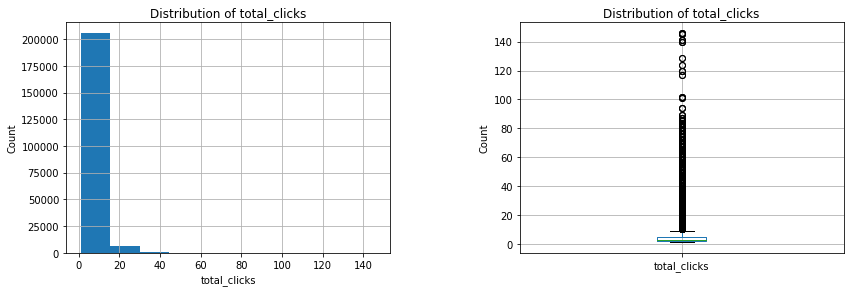

--------------------------------------------------------------------------------------------------------------------
count    213390.000000
mean        618.289308
std        1016.118483
min           0.000000
25%          88.023250
50%         245.936500
75%         688.801250
max       41554.168000
Name: seconds_per_session, dtype: float64


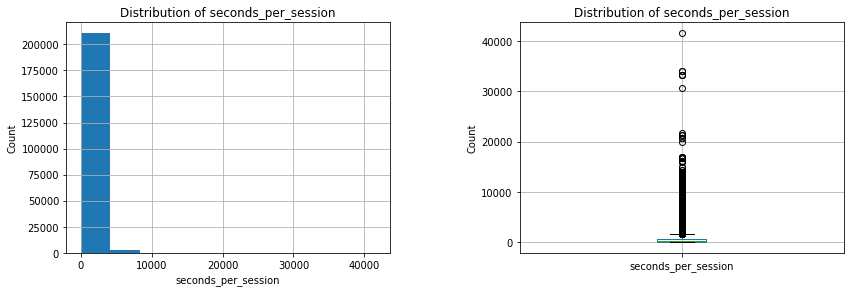

--------------------------------------------------------------------------------------------------------------------
count    213390.000000
mean          3.934369
std           4.421420
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         140.000000
Name: count_unique_items, dtype: float64


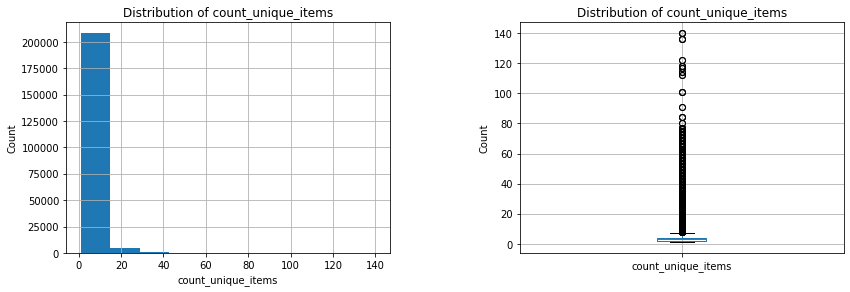

In [47]:
dp.stat_plots(test, 'total_clicks')
print('--------------------------------------------------------------------------------------------------------------------')
dp.stat_plots(test, 'seconds_per_session')
print('--------------------------------------------------------------------------------------------------------------------')
dp.stat_plots(test, 'count_unique_items')